In [17]:
import numpy as np  # 高效数值计算（如数组）
import pandas as pd  # 数据处理与分析 （如 DataFrame）
import matplotlib.pyplot as plt  # 数据可视化 （绘图）

In [18]:
path = 'datainfo2.txt'
data = pd.read_csv(path, header=None, names=['WY1','QF1X','QF1Y','YL1Y','DZ1','ND1','YL1W'],usecols=np.arange(7)) #选择前7列
#data = pd.read_csv(path, header=None, names=['WY1','WY2','QF1X','QF1Y','QF2X','QF2Y','DZ1','QZ1'],usecols=np.arange(8))
print(data.head())
print(data.min())
print(data.max())

        WY1      QF1X      QF1Y        YL1Y       DZ1       ND1      YL1W
0 -3.209500  0.019600  0.029467  120.666600  0.000025 -1.788380  8.766667
1 -3.172000  0.020967  0.028267  121.449997  0.000027 -1.820811  8.700000
2 -3.154667  0.018931  0.029655  121.233266  0.000025 -1.835040  8.700000
3 -3.136667  0.019200  0.030533  121.500000  0.000028 -1.845680  8.700000
4 -3.126000  0.018000  0.030400  121.533330  0.000024 -1.847675  8.666667
WY1    -35.153667
QF1X    -0.163793
QF1Y    -0.361233
YL1Y   -17.400067
DZ1      0.000023
ND1     -1.938007
YL1W     8.666667
dtype: float64
WY1      -3.038000
QF1X      0.056033
QF1Y      0.031300
YL1Y    183.333333
DZ1       0.000220
ND1       6.595414
YL1W     36.900002
dtype: float64


In [19]:
# data.drop(columns=['WY1','QF1X','QF1Y','DZ1','YL3W'],inplace=True) # 删除指定列
data = (data - data.min()) / (data.max() - data.min())
# data = data.loc[:,~(data==0).all()] # 删除全零列
# data = (data - data.mean()) / data.std() # 归一化特征
# X = np.matrix(data) 
X = np.matrix(data) # 针对二维数据
# m, n = X.shape
# cov = (X.T * X) / m
# U, S, V = np.linalg.svd(cov)
# for i in range(n):
#     if (np.sum(S[:i]) / np.sum(S)) >= 0.95:
#         X = np.dot(X, U[:,:i])
#         break
# k = 4    #目标维度为4类
k = 5      #将数据分为5类
m, n = X.shape # m行n列

In [20]:
# u[0].shape (1,9)
# X.shape, X[0:5,:] # (1767, 5)
# X[0] (1,9)
print(data.head())#归一化之后的输出，全部在[0，1]内；
print(X.shape)
data.max()

        WY1      QF1X      QF1Y      YL1Y       DZ1       ND1      YL1W
0  0.994660  0.834263  0.995329  0.687811  0.013206  0.017534  0.003542
1  0.995828  0.840480  0.992272  0.691714  0.019301  0.013734  0.001181
2  0.996367  0.831220  0.995810  0.690634  0.011174  0.012066  0.001181
3  0.996928  0.832444  0.998047  0.691963  0.026919  0.010819  0.001181
4  0.997260  0.826985  0.997707  0.692129  0.009142  0.010586  0.000000
(5275, 7)


WY1     1.0
QF1X    1.0
QF1Y    1.0
YL1Y    1.0
DZ1     1.0
ND1     1.0
YL1W    1.0
dtype: float64

In [21]:
def init_centroids(X, k):
    m, n = X.shape
    centroids = np.zeros((k, n)) # 初始化质心矩阵
    idx = np.random.randint(0, m ,k) # 随机选取k个索引 不同结果差异较大 np.random.randint会导致每次运行结果不同；
    
    for i in range(k):
        centroids[i,:] = X[idx[i], :] # 赋值对应的样本点
    return centroids

def find_closest_centroids(X, centroids): # 找到每个样本点最近的质心
    m = X.shape[0] # 样本数量
    k = centroids.shape[0] # 质心数量
    idx = np.zeros(m) # 存储每个样本最近的质心索引

    for i in range(m):
        min_dist = 100000000
        for j in range(k):
            # 计算欧式距离（平方距离，避免开根号优化计算）
            dist = np.sum((X[i,:] - centroids[j]) *(X[i,:] - centroids[j]).T)
            if dist < min_dist:
                min_dist = dist
                idx[i] = j # 更新最近的质心索引
    return idx

def compute_centroids(X, idx, k): # 重新计算每个簇的新质心位置（每个簇内索引样本均值）
    m, n = X.shape
    centroids = np.zeros((k, n)) # 存储新的质心坐标
    
    for i in range(k): # 遍历每一个簇（质心）i
        indices = np.where(idx == i) # 返回满足条件的原数组的索引，idx有几维就返回几个数组
        centroids[i,:] = (np.sum(X[indices,:], axis=1) / len(indices[0])).ravel()
        # print('{}: {}'.format(i+1,len(indices[0])))

    return centroids

def run_k_means(X, initial_centroids, max_iters): # 根据质心变化量判断是否提前终止
    m, n = X.shape
    k = initial_centroids.shape[0]
    idx = np.zeros(m) #初始化一个数组，保存每个样本最近的质心索引
    centroids = initial_centroids
    err = np.zeros(max_iters) # 保存每次迭代质心的变化量

    for i in range(max_iters):
        idx = find_closest_centroids(X, centroids)
        _centroids = compute_centroids(X, idx, k)
        err[i] = pow(np.sum(np.dot((centroids - _centroids),(centroids - _centroids).T)),0.5)
        if err[i] < 0.001:
            err =err[:i+1]
            return idx, centroids, err
        centroids = _centroids
    return idx, centroids, err # 样本分配结果 最终质心 误差数组

def em(X, u, sigma, alpha, k, max_iters):
    m, n = X.shape
    p = np.eye(m,k) # 初始化后验概率矩阵
    C = range(m) # 初始化聚类标签
    lld = 0
    _lld = 0
    llds = list(range(max_iters)) # llds：存储每次迭代的似然变化量
    
    for it in range(max_iters):
        for j in range(m): # 使用显式循环计算后验概率，效率低
            for i in range(k):
                # sigma[i] = sigma[i] + 1e-5 * np.eye(n) # 不需要
                p[j,i] = np.exp(-0.5*(X[j]-u[i]) * np.linalg.inv(sigma[i]) * (X[j]-u[i]).T) / (pow(2 * np.pi, n/2) * pow(np.linalg.det(sigma[i]),0.5))
                # if p[j,i] == 0:
                #     print(np.exp(-0.5*(X[j]-u[i]) * np.linalg.inv(sigma[i]) * (X[j]-u[i]).T))
        for i in range(k):
            p[:,i] = p[:,i] * alpha[i] #alpha为权重
        # 归一化得到各混合成分的后验概率                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            
        for j in range(m):
            p[j,:] = p[j,:] / np.sum(p[j,:])
        # print(p[0])

        # 更新参数
        for i in range(k):
            u[i] = np.zeros(n)
            for j in range(m):
                u[i] = u[i] + p[j,i]*X[j]
            u[i] = u[i] / np.sum(p[:,i]) # 更新均值
        for i in range(k):
            sigma[i] = np.matrix(np.zeros(sigma[i].shape))
            for j in range(m):
                sigma[i] = sigma[i] + p[j,i]*(X[j]-u[i]).T * (X[j]-u[i])
            sigma[i] = sigma[i] / np.sum(p[:,i]) # 更新协方差
        for i in range(k):
            alpha[i] = np.sum(p[:,i]) / m 
        _C = np.argmax(p,axis=1) # 每一行最大值的索引
        # if (C==_C).all(): # 两个数据所有元素相等 返回true
        #     return C,it
        _lld = 0
        for i in range(k):
            p[:,i] = p[:,i] * alpha[i]
        for j in range(m):
            _lld = _lld + np.log(np.sum(p[j,:]))     
        if abs(lld - _lld) < 0.0001: 
            return C,it,llds,u
        tmp = lld
        lld = _lld
        C = _C
        llds[it] = abs(tmp - _lld)
    return C,it,llds,u

    

In [22]:

initial_centroids = init_centroids(X, k)
idx, centroids,err = run_k_means(X, initial_centroids,200) # 最大迭代次数通常设置为100-300


In [23]:
for i in range(k):
    indices = np.where(idx == i)
    print('{}:{}'.format(i+1,len(indices[0])))
# 558 341 465 403 (100次结果)
# 527 496 124 620 (1000)
print(err) # 误差
print(centroids) # K-means聚类中心
# centroids = [[ 0.34274254, -0.48820469,  0.7014938 ,  0.75798088, -0.18446077],
#        [ 0.50090021, -0.44209445, -1.51959993, -0.22497453, -0.27302283],
#        [-2.04771394,  0.41651349,  0.0642282 , -0.16471628, -0.06738556],
#        [ 1.46434161,  0.56946315,  0.24040675, -0.66909167,  0.5641791 ]]

1:1033
2:449
3:1784
4:963
5:1046
[0.31611014 0.06967344 0.05253202 0.04108833 0.02544124 0.02351261
 0.0186548  0.01619196 0.01467886 0.01739636 0.02150408 0.02441375
 0.03595504 0.03453411 0.02983726 0.02598563 0.01939589 0.01608278
 0.01167767 0.00761473 0.00551508 0.0061955  0.00694413 0.00782576
 0.00835073 0.00977807 0.00922077 0.00919658 0.0102325  0.00962557
 0.01428788 0.01205625 0.0134127  0.01127186 0.01169604 0.00990733
 0.00917915 0.00961086 0.00760696 0.00796919 0.00734275 0.0084095
 0.00771541 0.00574284 0.00353595 0.00160559 0.00094488]
[[0.54195606 0.64720934 0.74150903 0.70083014 0.15956393 0.47047582
  0.47482255]
 [0.75720878 0.74268794 0.85386254 0.75771894 0.10519529 0.27643994
  0.26528215]
 [0.25758719 0.62935436 0.53843432 0.41620832 0.30511142 0.77964977
  0.76691834]
 [0.12442461 0.52980904 0.45560732 0.25948305 0.40026624 0.85751884
  0.86458798]
 [0.40516653 0.67383914 0.61896274 0.51220928 0.22194726 0.64677499
  0.63855596]]


In [24]:
sigma1 =sigma2 = sigma3 = sigma4 = sigma5 = np.diag([0.1]*n)
sigma =[sigma1,sigma2,sigma3,sigma4,sigma5]
# alpha = [0.25, 0.25, 0.25, 0.25]
alpha = [0.20, 0.20, 0.20, 0.20, 0.20]

# centroids = init_centroids(X, k)
C,iters,llds,u =em(X,centroids,sigma,alpha,k,500)
print('迭代{}次'.format(iters+1))
print('前10个样本的分类结果{}'.format(C[:10]))
print('gmm中心{}'.format(u))

C:\Users\15691\AppData\Local\Temp\ipykernel_52116\1592550703.py:65: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  p[j,i] = np.exp(-0.5*(X[j]-u[i]) * np.linalg.inv(sigma[i]) * (X[j]-u[i]).T) / (pow(2 * np.pi, n/2) * pow(np.linalg.det(sigma[i]),0.5))


迭代132次
前10个样本的分类结果[1 1 1 1 1 1 1 1 1 1]
gmm中心[[0.58644873 0.68390791 0.71713771 0.51524195 0.19079818 0.47085174
  0.5257867 ]
 [0.55742811 0.64743562 0.75824648 0.72495426 0.15665476 0.44652216
  0.44409868]
 [0.2635982  0.64357863 0.54221561 0.41698495 0.31123537 0.78965271
  0.76685755]
 [0.13725367 0.48963213 0.43934278 0.26112019 0.40131759 0.8030815
  0.86893546]
 [0.3814985  0.66740003 0.57684214 0.35048918 0.21322666 0.64487254
  0.63189602]]


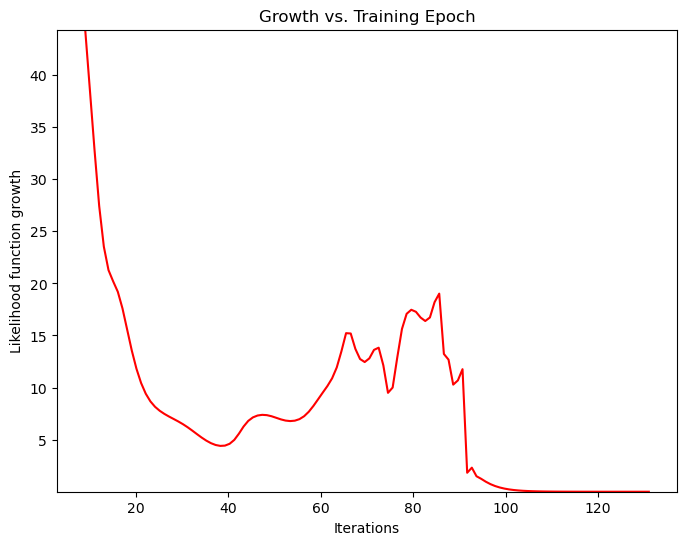

In [25]:
step = 9 # 从第9次迭代开始绘图，跳过前面不稳定的计算
x = np.linspace(step, iters, iters-step) # 一共 iters-step 个点
y = llds[step:iters] # 从llds数组中提取从step到iters的子数组
# y = list(np.array(y) * 100) # 每个元素乘100
fig, ax = plt.subplots(figsize=(8,6)) # fig绘图窗口，ax坐标系
ax.plot(x, y, 'r', label='Prediction') # 'r' 为红色线条
ax.set_ylim(min(y),max(y)) #确保曲线完全在坐标系内，无截断
ax.set_xlabel('Iterations')
ax.set_ylabel('Likelihood function growth')
ax.set_title('Growth vs. Training Epoch')
plt.show()

In [26]:
for i in range(k):                                 # 统计聚类结果中每个簇的样本数量
    indices = np.where(C == i)
    print('{}:{}'.format(i+1,len(indices[0])))
# 713 403 279 372 49次
# 186 620 217 744 19次
# 341 279 744 403 58次
# 217 403 806 341 22次

1:156
2:1595
3:2531
4:488
5:505


In [27]:
# 将分类结果添加为新的一列  Labelgmm 的值为 1,2,3,4,5
data['Labelgmm'] = C+1

# 保存带有分类结果的新数据到CSV文件中
data.to_csv('datainfo2gmm.csv', index=False)

In [28]:
# data = pd.read_csv(path, header=None, names=['yb1', 'yb2','yb3','yb4','wy1','wy2','wy3','wy4','zs'])
# data.insert(9,'leiBie',C)
# data.to_csv('GMMRes.txt',sep=',',index=False,header=None)
# 每个数据以,分隔 不保存序列 不保存列名
#import pandas as pd
data = pd.read_csv(path, header=None, names=['WY1','QF1X','QF1Y','YL1Y','DZ1','ND1','YL1W','UserTime'])
# data.insert(12,'leiBie',C)
data['leiBie'] = C
data.to_csv('GMM.txt',sep=',',index=False,header=None)

In [29]:
data = pd.read_csv('GMM.txt', header=None, names=['WY1','QF1X','QF1Y','YL1Y','DZ1','ND1','YL1W','UserTime','leiBie'])
data.insert(9,'x',range(1,5276))
data.head()

,WY1,QF1X,QF1Y,YL1Y,DZ1,ND1,YL1W,UserTime,leiBie,x
0,-3.209500,0.019600,0.029467,120.666600,0.000025,-1.788380,8.766667,2023/4/24 0:00,1,1
1,-3.172000,0.020967,0.028267,121.449997,0.000027,-1.820811,8.700000,2023/4/24 0:30,1,2
2,-3.154667,0.018931,0.029655,121.233266,0.000025,-1.835040,8.700000,2023/4/24 1:00,1,3
3,-3.136667,0.019200,0.030533,121.500000,0.000028,-1.845680,8.700000,2023/4/24 1:30,1,4
4,-3.126000,0.018000,0.030400,121.533330,0.000024,-1.847675,8.666667,2023/4/24 2:00,1,5


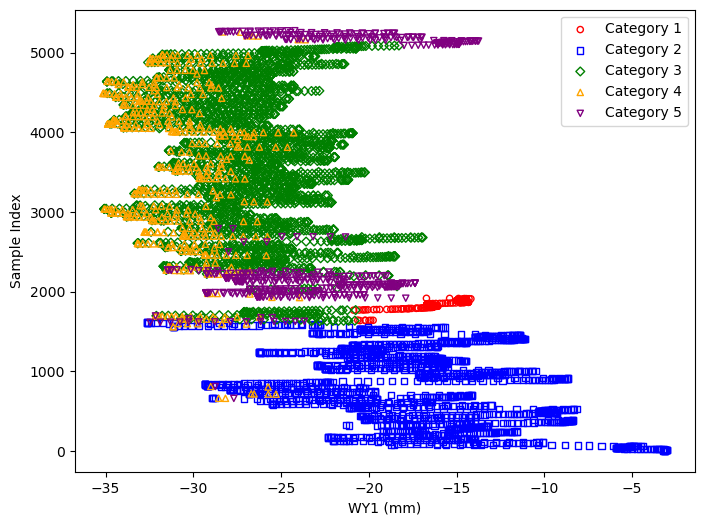

In [36]:
r1 = data[data['leiBie'].isin([0])]
r2 = data[data['leiBie'].isin([1])]
r3 = data[data['leiBie'].isin([2])]
r4 = data[data['leiBie'].isin([3])]
r5 = data[data['leiBie'].isin([4])]

fig, ax = plt.subplots(figsize=(8,6))
# ax.scatter(r1['WY1'],r1['x'],s=50, facecolors='none', marker='o',edgecolors='g', label='k=1')
# ax.scatter(r2['WY1'],r2['x'],s=50, facecolors='none', marker='o',edgecolors='b', label='k=2')
# ax.scatter(r3['WY1'],r3['x'],s=50, c='r', marker='+', label='k=3')
# ax.scatter(r4['WY1'],r4['x'],s=50, c='black', marker='x', label='k=4')
ax.scatter(r1['WY1'], r1['x'], s=20, facecolors='none', marker='o', edgecolors='red', label='Category 1')    # 空心红色圆圈
ax.scatter(r2['WY1'], r2['x'], s=20, facecolors='none', marker='s', edgecolors='blue', label='Category 2')   # 空心蓝色方框
ax.scatter(r3['WY1'], r3['x'], s=20, facecolors='none', marker='D', edgecolors='g', label='Category 3')      # 空心绿色菱形
ax.scatter(r4['WY1'], r4['x'], s=20, facecolors='none', marker='^', edgecolors='orange', label='Category 4') # 空心橙色正三角
ax.scatter(r5['WY1'], r5['x'], s=20, facecolors='none', marker='v', edgecolors='purple', label='Category 5')  # 空心紫色倒三角

ax.legend()
ax.set_xlabel('WY1 (mm)')
ax.set_ylabel('Sample Index')
# plt.gca().axes.get_yaxis().set_visible(False) # 隐藏纵轴
plt.show()

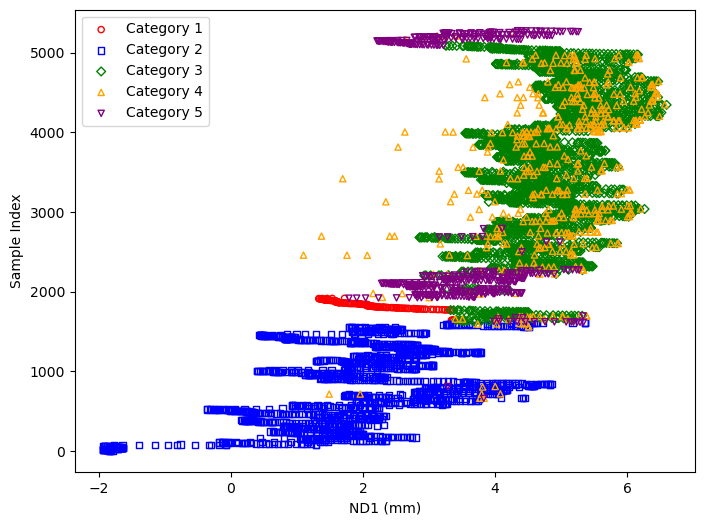

In [33]:
fig, ax = plt.subplots(figsize=(8,6))
# ax.scatter(r1['ND1'],r1['x'],s=50, facecolors='none', marker='o',edgecolors='g', label='k=1')
# ax.scatter(r2['ND1'],r2['x'],s=50, facecolors='none', marker='o',edgecolors='b', label='k=2')
# ax.scatter(r3['ND1'],r3['x'],s=50, c='r', marker='+', label='k=3')
# ax.scatter(r4['ND1'],r4['x'],s=50, c='black', marker='x', label='k=4')
ax.scatter(r1['ND1'], r1['x'], s=20, facecolors='none', marker='o', edgecolors='red', label='Category 1')    # 空心红色圆圈
ax.scatter(r2['ND1'], r2['x'], s=20, facecolors='none', marker='s', edgecolors='blue', label='Category 2')   # 空心蓝色方框
ax.scatter(r3['ND1'], r3['x'], s=20, facecolors='none', marker='D', edgecolors='g', label='Category 3')      # 空心绿色菱形
ax.scatter(r4['ND1'], r4['x'], s=20, facecolors='none', marker='^', edgecolors='orange', label='Category 4') # 空心橙色正三角
ax.scatter(r5['ND1'], r5['x'], s=20, facecolors='none', marker='v', edgecolors='purple', label='Category 5')  # 空心紫色倒三角

ax.legend()
ax.set_xlabel('ND1 (mm)')
ax.set_ylabel('Sample Index')
# plt.gca().axes.get_yaxis().set_visible(False)
plt.show()

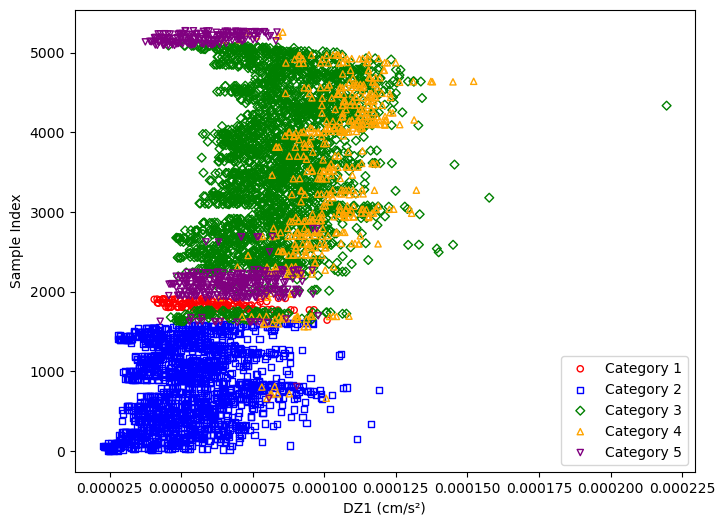

In [34]:
fig, ax = plt.subplots(figsize=(8,6))
# ax.scatter(r1['DZ1'],r1['x'],s=50, facecolors='none', marker='o',edgecolors='g', label='k=1')
# ax.scatter(r2['DZ1'],r2['x'],s=50, facecolors='none', marker='o',edgecolors='b', label='k=2')
# ax.scatter(r3['DZ1'],r3['x'],s=50, c='r', marker='+', label='k=3')
# ax.scatter(r4['DZ1'],r4['x'],s=50, c='black', marker='x', label='k=4')
ax.scatter(r1['DZ1'], r1['x'], s=20, facecolors='none', marker='o', edgecolors='red', label='Category 1')    # 空心红色圆圈
ax.scatter(r2['DZ1'], r2['x'], s=20, facecolors='none', marker='s', edgecolors='blue', label='Category 2')   # 空心蓝色方框
ax.scatter(r3['DZ1'], r3['x'], s=20, facecolors='none', marker='D', edgecolors='g', label='Category 3')      # 空心绿色菱形
ax.scatter(r4['DZ1'], r4['x'], s=20, facecolors='none', marker='^', edgecolors='orange', label='Category 4') # 空心橙色正三角
ax.scatter(r5['DZ1'], r5['x'], s=20, facecolors='none', marker='v', edgecolors='purple', label='Category 5')  # 空心紫色倒三角

ax.legend()
ax.set_xlabel('DZ1 (cm/s²)')
ax.set_ylabel('Sample Index')
# plt.gca().axes.get_yaxis().set_visible(False)
plt.show()

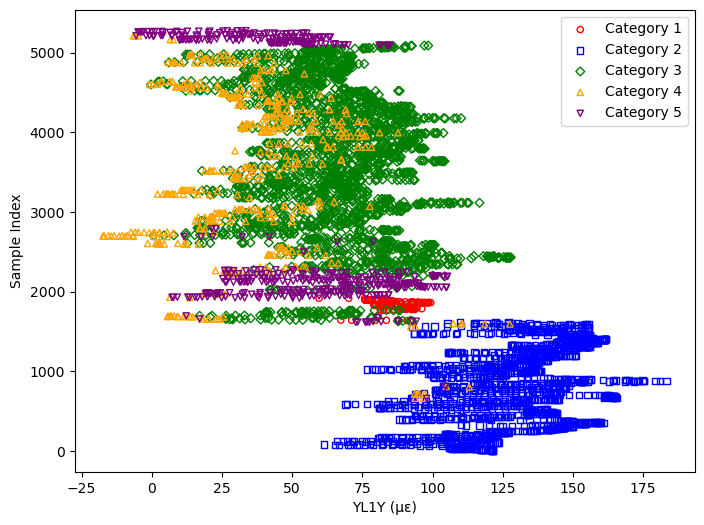

In [35]:
fig, ax = plt.subplots(figsize=(8,6))
# ax.scatter(r1['YL1Y'],r1['x'],s=50, facecolors='none', marker='o',edgecolors='g', label='k=1')
# ax.scatter(r2['YL1Y'],r2['x'],s=50, facecolors='none', marker='o',edgecolors='b', label='k=2')
# ax.scatter(r3['YL1Y'],r3['x'],s=50, c='r', marker='+', label='k=3')
# ax.scatter(r4['YL1Y'],r4['x'],s=50, c='black', marker='x', label='k=4')
ax.scatter(r1['YL1Y'], r1['x'], s=20, facecolors='none', marker='o', edgecolors='red', label='Category 1')    # 空心红色圆圈
ax.scatter(r2['YL1Y'], r2['x'], s=20, facecolors='none', marker='s', edgecolors='blue', label='Category 2')   # 空心蓝色方框
ax.scatter(r3['YL1Y'], r3['x'], s=20, facecolors='none', marker='D', edgecolors='g', label='Category 3')      # 空心绿色菱形
ax.scatter(r4['YL1Y'], r4['x'], s=20, facecolors='none', marker='^', edgecolors='orange', label='Category 4') # 空心橙色正三角
ax.scatter(r5['YL1Y'], r5['x'], s=20, facecolors='none', marker='v', edgecolors='purple', label='Category 5')  # 空心紫色倒三角

ax.legend()
ax.set_xlabel('YL1Y (με)')
ax.set_ylabel('Sample Index')
# plt.gca().axes.get_yaxis().set_visible(False)
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(r1['yb1'],r1['yb2'],s=50, facecolors='none', marker='o',edgecolors='g', label='k=1')
ax.scatter(r2['yb1'],r2['yb2'],s=50, facecolors='none', marker='o',edgecolors='b', label='k=2')
ax.scatter(r3['yb1'],r3['yb2'],s=50, c='r', marker='+', label='k=3')
ax.scatter(r4['yb1'],r4['yb2'],s=50, c='black', marker='x', label='k=4')
ax.legend()
plt.show()

In [ ]:
data = pd.read_csv('GMMRes3X145.txt', header=None, names=['yb1', 'yb2','wy1','wy2','zs1','zs2','time','leiBie'])
leiBie = data['leiBie']
data.drop(columns=['wy1','wy2','time','leiBie'],inplace=True)
data = (data - data.min()) / (data.max() - data.min())
data.insert(4,'leiBie',leiBie)
data.insert(5,'x',range(1,3397))
data.head()

In [ ]:
r1 = data[data['leiBie'].isin([0])]
r2 = data[data['leiBie'].isin([1])]
r3 = data[data['leiBie'].isin([2])]
r4 = data[data['leiBie'].isin([3])]

fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(r1['yb1'],r1['zs1'],s=50, facecolors='none', marker='o',edgecolors='g', label='k=1')
ax.scatter(r2['yb1'],r2['zs1'],s=50, facecolors='none', marker='o',edgecolors='b', label='k=2')
ax.scatter(r3['yb1'],r3['zs1'],s=50, c='r', marker='+', label='k=3')
ax.scatter(r4['yb1'],r4['zs1'],s=50, c='black', marker='x', label='k=4')
ax.legend()
plt.show()

In [ ]:
# 读取功效系数法的结果
leiBie = pd.read_csv('GMMResGX.txt', header=None, names=['leiBie'])
data = pd.read_csv('GMMRes3X145.txt', header=None, names=['yb1', 'yb2','wy1','wy2','zs1','zs2','time','tmp'])
data.insert(8,'x',range(1,3397))
data.insert(9,'leiBie',leiBie)

r1 = data[data['leiBie'].isin([0])]
r3 = data[data['leiBie'].isin([1])]
r2 = data[data['leiBie'].isin([2])]
r4 = data[data['leiBie'].isin([3])]

In [ ]:
fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(r1['yb1'],r1['x'],s=50, facecolors='none', marker='o',edgecolors='g', label='Status Ⅰ')
ax.scatter(r2['yb1'],r2['x'],s=50, c='r', marker='+', label='Status Ⅱ')
ax.scatter(r3['yb1'],r3['x'],s=50, facecolors='none', marker='o',edgecolors='b', label='Status Ⅲ')
ax.scatter(r4['yb1'],r4['x'],s=50, c='black', marker='x', label='Status Ⅳ')
ax.legend()
ax.set_xlabel('Strain measurement values of 3X1YB01')
plt.gca().axes.get_yaxis().set_visible(False)
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(r1['yb2'],r1['x'],s=50, facecolors='none', marker='o',edgecolors='g', label='Status Ⅰ')
ax.scatter(r2['yb2'],r2['x'],s=50, c='r', marker='+', label='Status Ⅱ')
ax.scatter(r3['yb2'],r3['x'],s=50, facecolors='none', marker='o',edgecolors='b', label='Status Ⅲ')
ax.scatter(r4['yb2'],r4['x'],s=50, c='black', marker='x', label='Status Ⅳ')
ax.legend()
ax.set_xlabel('Strain measurement values of 3X1YB02')
plt.gca().axes.get_yaxis().set_visible(False)
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(r1['zs1'],r1['x'],s=50, facecolors='none', marker='o',edgecolors='g', label='Status Ⅰ')
ax.scatter(r2['zs1'],r2['x'],s=50, c='r', marker='+', label='Status Ⅱ')
ax.scatter(r3['zs1'],r3['x'],s=50, facecolors='none', marker='o',edgecolors='b', label='Status Ⅲ')
ax.scatter(r4['zs1'],r4['x'],s=50, c='black', marker='x', label='Status Ⅳ')
ax.legend()
ax.set_xlabel('Vibration velocity measurement value of 3X1ZS01')
plt.gca().axes.get_yaxis().set_visible(False)
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(r1['zs2'],r1['x'],s=50, facecolors='none', marker='o',edgecolors='g', label='Status Ⅰ')
ax.scatter(r2['zs2'],r2['x'],s=50, c='r', marker='+', label='Status Ⅱ')
ax.scatter(r3['zs2'],r3['x'],s=50, facecolors='none', marker='o',edgecolors='b', label='Status Ⅲ')
ax.scatter(r4['zs2'],r4['x'],s=50, c='black', marker='x', label='Status Ⅳ')
ax.legend()
ax.set_xlabel('Vibration velocity measurement value of 3X1ZS02')
plt.gca().axes.get_yaxis().set_visible(False)
plt.show()